I ran across this dataset in a project, looking at the histogram, the data looked like it was a mixture of an exponential and a gaussian distribution. So I tried using EM to extract the parameters. Estimation was pretty slow on a CPU, tried it on a GPU using tensorflow.  The only difference in the code for tensorflow and numpy turned out to be replacing "np." with "tf." in the functions. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as pl

In [2]:
import tensorflow as tf
import numpy as np

#### Load data and plot histogram

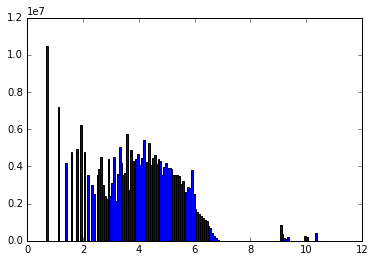

In [3]:
with open('data.npy') as f:
    data = np.load(f)

cnts_and_bins = pl.hist(data, bins=150)

 Looks like the data is being generated from a mixture model, a mixture of Gaussian distribution and an exponential distribution . We can use tensorflow and expectation maximization to fit the two distributions. 
 
 Let us first generate a toy dataset and make sure our implementation is correct. 
 
 We will start with 2 random variables $X_1$ and $X_2$, $X_1$ is exponentially distributed with parameter $\lambda$. $X_2$ has a Gaussian distribution with mean $\mu$ and variance $\sigma^2$
 
 Let $pi$ be the prior probability that a sample is from X1, 
 $p(x/X_1) = \pi$ and correspondingly, $p(x/X_2) = 1-\pi $
 
To maximize the log likelihood, with $\theta$ being the set of all parameters,
$ argmax_{\theta}(ln(p(D/\theta))) = argmax_{\theta}(ln(\prod_{i=1}^{N} p(x_i/X_1)\cdotp(X_1) + p(x_i/X_2)\cdotp(X_2)$))

$= \sum_{i=1}^{N} ln(exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)) $

Where 

$exp(x_i/\theta) = \lambda e^{-\lambda x_i}$
and 
$N(x_i/\theta) = \frac{1}{2\pi\sigma^2}e^{-\frac{(x_i - \mu)^2}{2\sigma^2}}$


Differentiating and equating to 0, 
* (a) wrt $\lambda$ (parameter for  exp)

$\frac{\partial}{\partial \lambda}  = \sum_{i=1}^{N} \frac{e^{-\lambda x_i}(1 - x_i)}{exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)}  $
$\ = \sum_{i=1}^{N} \frac{\lambda e^{-\lambda x_i}}{exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)} \cdot \frac{(1 - \lambda x_i)}{\lambda} $
$ = \sum_{i=1}^{N} \frac{exp(x_i/\theta)}{exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)} \cdot \frac{(1 - \lambda x_i)}{\lambda} $
Let
$\frac{exp(x_i/\theta)}{exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)} = \gamma_{exp_i}$

Where $\gamma{exp_i}$, is the responsibility factor, or the probability of $x_i$ being part of the exponential part of the mixture.

Solving for $\lambda$

$0 = \sum_{i=1}^{N} \gamma_{exp_i} \cdot (1/\lambda - x_i) $
or

$\lambda = \frac {\sum_{i=1}^{N} \gamma_{exp_i}} {\sum_{i=1}^{N} \gamma_{exp_i} x_i}$

* (b) wrt $\mu$ and $\sigma$ (parameters for N), a similar exercise with the normal distribution yields:

$\mu = \frac {\sum_{i=1}^{N} \gamma_{norm_i} x_i} {\sum_{i=1}^{N} \gamma_{norm_i}}  $ 

$\sigma = \sqrt{\frac { \sum_{i=1}^{N} \gamma_{norm_i} (x_i - \mu)^2 } {\sum_{i=1}^{N} \gamma_{norm_i}} }$

and 

$\gamma_{norm_i}  =  \frac{N(x_i/\theta)}{exp(x_i/\theta)\cdot\pi + N(x_i/\theta)\cdot(1-\pi)} $


THe EM process involves alternatively computing $\gamma$ (E step) and estimating $\mu$, $\sigma$ and $\lambda$ (M step) 

##### Coding it up for tensorflow

In [4]:
def normpdf(x, mu, sigma):
    return tf.sqrt(1/(2*np.pi*tf.square(sigma))) * tf.exp(-tf.square(x-mu)/(2*tf.square(sigma)))

def exppdf(t, lmbda):
    expvals = lmbda*tf.exp(-1.*lmbda*t)
    return expvals

def gamma_exp(pi_exp, mu, sig, lmbda, t):
    num = pi_exp * exppdf(t, lmbda)
    den = num + (1-pi_exp)*normpdf(t, mu, sig)
    return num/den

def gamma_norm(pi_norm, mu, sig, lmbda, t):
    num = pi_norm * normpdf(t, mu, sig)
    den = num + (1-pi_norm)*exppdf(t, lmbda)
    return num/den

def exp_max_iter(t, pi, mu, sig, lmbda):
    ge = gamma_exp(pi, mu, sig, lmbda, t)
    gn = gamma_norm(1-pi, mu, sig, lmbda, t)
    ge_sum = tf.reduce_sum(ge)
    lmbda_hat = ge_sum/tf.reduce_sum(ge*t)
    gnsum = tf.reduce_sum(gn)
    mu_hat = tf.reduce_sum(gn*t)/gnsum
    sig_hat = tf.sqrt(tf.reduce_sum(gn*(t-mu_hat)*(t-mu_hat))/gnsum)
    pi_hat = ge_sum/ t.get_shape()[0].value
    return pi_hat, mu_hat, sig_hat, lmbda_hat,  gnsum/ t.get_shape()[0].value


#### Testing on a sample data set

('Shape of D:', (100000000,))


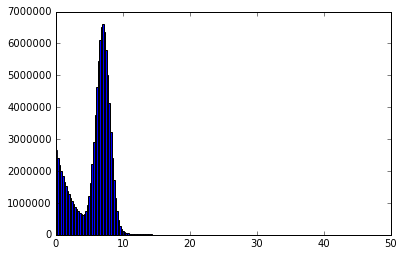

In [5]:

pi_actual = 0.3 
mu_actual = 7.
sigma_actual = 1.
lambda_actual = 0.4

N = int(1e8) #Data set with 100 million records
D = np.zeros((N), dtype=np.float64)

num_exp = int(pi_actual*N)

D[:num_exp] = np.random.exponential(1./lambda_actual, num_exp)
D[num_exp:] = np.random.normal(mu_actual, sigma_actual, N - num_exp)

histdata = pl.hist(D, bins=200)
print ("Shape of D:", D.shape)

### Running the iterations in tensorflow

In [6]:
sess = tf.InteractiveSession()


In [7]:
x = tf.placeholder(dtype=tf.float32, shape=D.shape)

In [8]:
import time
pi = 0.5 
lmbda = 1.
mu = 2.
sig = 3.
num_iterations = 20
start = time.time()
for i in range(num_iterations):
    pi_hat, mu_hat, sig_hat, lmbda_hat, pi_hat_2 = exp_max_iter(x, pi, mu, sig, lmbda)
    pi, mu, sig, lmbda, p2 = sess.run([pi_hat, mu_hat, sig_hat, lmbda_hat, pi_hat_2], {x:D})
end = time.time()
print("pi: actual %f, estimated %f, error %f"%(pi_actual, pi, (pi_actual - pi)/pi_actual))
print("mu: actual %f, estimated %f, error %f"%(mu_actual, mu, (mu_actual - mu)/mu_actual))
print("sigma: actual %f, estimated %f, error %f"%(sigma_actual, sig, (sigma_actual - sig)/sigma_actual))
print("lambda: actual %f, estimated %f, error %f"%(lambda_actual, lmbda, (lambda_actual - lmbda)/lambda_actual))
print("Total process time %f seconds, %f seconds per iteration"%(end-start, (end-start)/20))

pi: actual 0.300000, estimated 0.299904, error 0.000319
mu: actual 7.000000, estimated 6.999922, error 0.000011
sigma: actual 1.000000, estimated 1.000253, error -0.000253
lambda: actual 0.400000, estimated 0.400113, error -0.000282
Total process time 11.137076 seconds, 0.556854 seconds per iteration


Histogram of the samples that have a higher probability to have come from the exponential distribution

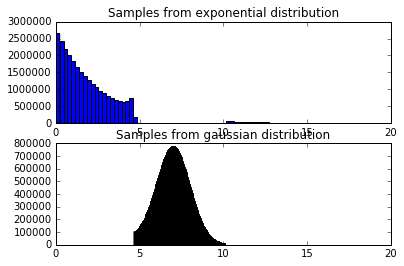

In [9]:
ge = gamma_exp(pi, mu, sig, lmbda, x)
pi_i = sess.run(ge, {x:D})
pl.subplot(2,1,1)
n, bins, patches = pl.hist(D[pi_i>0.5],bins=200)
pl.xlim(0,20)
pl.title('Samples from exponential distribution')
pl.subplot(2,1,2)
n, bins, patches = pl.hist(D[pi_i<0.5],bins=200)
pl.xlim(0,20)
pl.title('Samples from gaussian distribution')



Although this method provides a good estimate, it is very sensitive to initializations.  Some initiailizations with a lot of overlap can cause the values to explode..